In [1]:
import netCDF4
import numpy as np
import datetime
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline
import math as m
import pandas as pd

### Reading data from file

In [2]:
f = netCDF4.Dataset('rtofs_glo_3dz_f024_daily_3zvio.nc')
#print(f)

In [3]:
f2 = netCDF4.Dataset('rtofs_glo_3dz_f024_daily_3zuio.nc')
#print(f2)

In [4]:
print(f.variables.keys()) # get all variable names

[u'MT', u'Date', u'Depth', u'Y', u'X', u'Latitude', u'Longitude', u'v']


In [5]:
temp = f.variables['v']
#print(temp)

In [6]:
for d in f.dimensions.items():
    print(d)

(u'MT', <type 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'MT', size = 1
)
(u'Y', <type 'netCDF4._netCDF4.Dimension'>: name = 'Y', size = 3298
)
(u'X', <type 'netCDF4._netCDF4.Dimension'>: name = 'X', size = 4500
)
(u'Depth', <type 'netCDF4._netCDF4.Dimension'>: name = 'Depth', size = 33
)


In [7]:
print(temp.dimensions)
print(temp.shape)

(u'MT', u'Depth', u'Y', u'X')
(1, 33, 3298, 4500)


In [6]:
mt = f.variables['MT']
depth = f.variables['Depth']
x,y = f.variables['X'], f.variables['Y']
v = f.variables['v']
u = f2.variables['u']
#print(mt)
#print(x)
#print(v)
#print(u)

#### Shapes of basic arrays

In [8]:
print(x.shape[0])
print(y.shape[0])

4500
3298


#### Time and depth variables

In [7]:
time = mt[:]  # Reads the netCDF variable MT, array of one element
#print(time)
dep = depth[:] # examine depth array
#print(dep)

### Extracting lats and lons 

In [8]:
xx,yy = x[:],y[:]
#print('shape of temp variable: %s' % repr(temp.shape))
#tempslice = temp[0, dep < 100., yy > yy.max()/2, xx > xx.max()/2]
#print('shape of temp slice: %s' % repr(tempslice.shape))

In [9]:
lat, lng = f.variables['Latitude'], f.variables['Longitude']
#print(lng)

In [10]:
# extract lat/lon values (in degrees) to numpy arrays
latvals = lat[:]; lngvals = lng[:]

In [11]:
%%time
for i in range(3298):
    for j in range(4500):
        lngvals[i, j] -= 254.12

CPU times: user 3min 40s, sys: 1.53 s, total: 3min 42s
Wall time: 3min 40s


In [12]:
print(lngvals[0:3297, :].max())
print(lngvals.min())

180.0
-180.0


## Initial attempt of point search

### Решаем задачу: зная широту и долготу, найти квадрат (4 точки со значениями y и x) такой, что исходная точка лежит в этом квадрате

In [13]:
def pointSearch(pLat, pLng):
    goalX = -1
    goalY = -1
    epsX = 100.
    epsY = 100.
    for i in range(x.shape[0] - 1):
        if ((lngvals[0, i]  <= pLng) & (lngvals[0, i + 1] > pLng) & (epsX > 0.01)):
            goalX = i
            epsX = pLng -  lngvals[0, i]
    if (goalX == -1):
        print('Smth with X went wrong')

    for j in range(y.shape[0] - 1):
        if (lngvals[j, goalX] > pLng):
            while (lngvals[j, goalX] > pLng):
                goalX -= 1
        if (lngvals[j, goalX + 1] < pLng):
            while (lngvals[j, goalX] < pLng):
                goalX += 1
        if ((latvals[j, goalX] <= pLat) & (latvals[j + 1, goalX] > pLat) & (epsY > 0.01)):
            goalY = j
            epsY = pLat - latvals[j, goalX]
    if (goalY == -1):
        print('Smth went wrong with Y')
            
            
    print(goalX, goalY)
    return (goalY, goalX)

In [16]:
a = pointSearch(78., -120.)
print(a)
print(latvals[a], lngvals[a])

Smth went wrong with Y
(1125, -1)
(-1, 1125)
(89.97772, 765.0)


In [18]:
print(latvals[3297, 4400])
print(latvals[3270, 4400])
print(lngvals[3297, 4400])
print(lngvals[3270, 4400])

52.183796
52.180405
540.0056
179.70361


In [19]:
print(lngvals[0, 0])
print(lngvals[0, 4499])
print(lngvals[3297, 0])
print(lngvals[3297, 4499])

-179.95996
179.95996
-180.0
540.0


In [20]:
print(lngvals.min())
print(lngvals[0:3296, :].max())

-180.0
179.99988


In [41]:
print(latvals.min())
print(latvals.max())

-78.64
89.97772


In [14]:
def cellIdentBool(P1, P2, P3, P4, P):
    ex = [P2[0]-P1[0],P2[1]-P1[1]]
    ey = [P4[0]-P1[0],P4[1]-P1[1]]
    exs = [P4[0]-P3[0],P4[1]-P3[1]]
    eys = [P2[0]-P3[0],P2[1]-P3[1]]
    #print('ex, ey, exs, eys:', ex, ey, exs, eys)
    
    a = np.array([[ex[0], ey[0]], [ex[1], ey[1]]])
    b = np.array([P[0]-P1[0], P[1]-P1[1]])
    #print("A, b:", a, b)
    xxx = np.linalg.solve(a, b)
    c = np.array([[exs[0], eys[0]], [exs[1], eys[1]]])
    b = np.array([P[0]-P3[0], P[1]-P3[1]])
    yyy = np.linalg.solve(c, b)
    #if ((xxx[0]>=0 == False) or ([xxx[1]>=0] == False) or ([yyy[0]>=0] == False) or ([yyy[1]>=0] == False)):
     #   return False
    #else:
    return ([xxx[0]>=0], [xxx[1]>=0], [yyy[0]>=0], [yyy[1]>=0])
    #return ((xxx[0]>=0) and (xxx[1]>=0) and (yyy[0]>=0) and (yyy[1]>=0))

In [23]:
print(cellIdentBool([-58.394382, 122.079956], [-58.352432, 122.079956], \
                    [-58.352432, 122.160034], [-58.394382, 122.160034], [-37.352833, 122.160034]))


([True], [True], [False], [True])


In [ ]:
print(cellIdentBool([latvals[1000, 600], lngvals[1000, 600]], \
                     [latvals[1000, 601], lngvals[1000, 601]], \
                     [latvals[1001, 601], lngvals[1001, 601]], \
                     [latvals[1001, 600], lngvals[1001, 600]], \
                     [latvals[600, 599], lngvals[600, 599]]))

In [ ]:
print(cellIdentBool([0.,0.], [1.,0.], [1.,1.], [0.,1.], [-0.5,-0.6]))

In [ ]:
print(lngvals[1516, 4498], latvals[1516, 4498])
print(lngvals[1516, 4499], latvals[1516, 4499])
print(lngvals[1516, 0], latvals[1516, 0])

### Final (so far) version of cell search

In [15]:
def imod(i):
    return i % x.shape[0]

def jmod(j):
    return j % y.shape[0]

In [16]:
def searchPoint(pLat, pLng):
    if (pLat < -78.64):
        pLat = 89.
    if (pLat > 89.9502):
        pLat = -78.
    if (pLng < -180.):
        pLng = 180.
    if (pLng > 180.):
        pLng = -180.
    res = False
    i = int(x.shape[0] / 2)
    j = int(y.shape[0] / 2)
    counter = 0
    goal = [-1, -1]
    while (res == False):
        counter += 1
        if (counter > 8000):
            return [j, i, False]
        
        j = jmod(j)
        i = imod(i)
        
        #p1 = [lngvals[j, i], latvals[j, i]] 
        #p2 = [lngvals[j, imod(i+1)], latvals[j, imod(i+1)]]
        #p3 = [lngvals[jmod(j+1), imod(i+1)], latvals[jmod(j+1), imod(i+1)]]
        #p4 = [lngvals[jmod(j+1), i], latvals[jmod(j+1), i]]
        #p = [pLng, pLat]
        p1 = [latvals[j, i], lngvals[j, i]] 
        p2 = [latvals[j, imod(i+1)], lngvals[j, imod(i+1)]]
        p3 = [latvals[jmod(j+1), imod(i+1)], lngvals[jmod(j+1), imod(i+1)]]
        p4 = [latvals[jmod(j+1), i], lngvals[jmod(j+1), i]]
        p = [pLat, pLng]
        out = cellIdentBool(p1, p2, p3, p4, p)
        #if (counter > 7990):
            #print(out)
        if ((not out[0][0]) | (not out[1][0])) :
            if (not out[0][0]):
                i = imod((i-1))
            if (not out[1][0]):
                j = jmod((j-1))
        else:
            if (not out[2][0]):
                i = imod((i+1))
            if (not out[3][0]):
                j = jmod((j+1))
        if ((out[0][0]) and (out[1][0]) and (out[2][0]) and (out[1][0])):
            res = True
            goal = [j, i, res]
    return goal

In [29]:
print(latvals[1000, 600], lngvals[1000, 600])
print(latvals[600, 599], lngvals[600,599])
print(latvals[601, 599], lngvals[601,599])
print(latvals[600, 600], lngvals[600,600])
print(latvals[601, 600], lngvals[601,600])

(-37.352833, -131.95996)
(-58.394382, -132.04004)
(-58.352432, -132.04004)
(-58.394382, -131.95996)
(-58.352432, -131.95996)


In [76]:
searchPoint(latvals[1000, 600], lngvals[1000, 600])

[1000, 3787, True]

In [24]:
goal = searchPoint(0., 1.)
print(goal)
print(goal == None)
if (goal != None):
    print(latvals[goal[0], goal[1]], lngvals[goal[0], goal[1]])

[1504, 2262, True]
False
(0.0, 0.9999951)


In [17]:
#3298 4500 
def cellRho(lats, lngs):
    # takes two arrays with first 4 comps as coords of cell knots and fifth comps as coords of given point
    return np.sqrt(sum(((lats[i] - lats[4])**2 + (lngs[i] - lngs[4])**2) for i in range(0, 4)))

def cellForm(y, x, goal):
    lats = [latvals[y, x], latvals[jmod(y+1), x], latvals[y, imod(x+1)], latvals[jmod(y+1), imod(x+1)], goal[0]]
    lngs = [lngvals[y, x], lngvals[jmod(y+1), x], lngvals[y, imod(x+1)], lngvals[jmod(y+1), imod(x+1)], goal[1]]
    return [lats, lngs]

def cellRhoMinimize(LL, goal, booly):
    res = cellRho(cellForm(LL[0], LL[1], goal)[0], cellForm(LL[0], LL[1], goal)[1])
    igoal = LL[1]
    jgoal = LL[0]
    
    if (booly == True):
        eps = 20
    else:
        eps = 300
        
    i = imod(LL[1] - eps)
    j = jmod(LL[0] - eps)
    counter1 = 0
    counter2 = 0
    while (counter1 < 2 * eps):
        while (counter2 < 2 * eps):
            counter2 += 1
            actualRho = cellRho(cellForm(j, i, goal)[0], cellForm(j, i, goal)[1])
            #print('i, j, rho: ' + str(i) + '  ' + str(j) + '  ' + str(actualRho))
            if (actualRho < res):
                res = actualRho
                igoal = i
                jgoal = j
            i = imod(i + 1)
        counter2 = 0
        counter1 += 1
        j = jmod(j + 1)
        i = imod(LL[1] - eps)
            
    return [res, jgoal, igoal]

In [47]:
def minim(pLat, pLng):
    result = searchPoint(pLat, pLng)
    LL = result[0:2] #returns [j,i]
    booly = result[2]

    LU = [jmod(LL[0] + 1), LL[1]]
    RL = [LL[0], imod(LL[1] + 1)]
    RU = [jmod(LL[0] + 1), imod(LL[0] + 1)]
    localLats = [latvals[LL[0], LL[1]], latvals[LU[0], LU[1]], latvals[RL[0], RL[1]], latvals[RU[0], RU[1]], pLat]
    localLngs = [lngvals[LL[0], LL[1]], lngvals[LU[0], LU[1]], lngvals[RL[0], RL[1]], lngvals[RU[0], RU[1]], pLng]
    #print('given: ' + str(pLat) + ', ' + str(pLng))
    #print('LL: ' + str(LL[0]) + ', ' + str(LL[1]))
    #print('LU: ' + str(LU[0]) + ', ' + str(LU[1]))
    #print('RL: ' + str(RL[0]) + ', ' + str(RL[1]))
    #print('RU: ' + str(RU[0]) + ', ' + str(RU[1]))
    #print('coords of cell are: \n' + str(latvals[LL[0], LL[1]]) + ', ' + str(lngvals[LL[0], LL[1]]) + '\n')
    #print(str(latvals[LU[0], LU[1]]) + ', ' + str(lngvals[LU[0], LU[1]]) + '\n')
    #print(str(latvals[RL[0], RL[1]]) + ', ' + str(lngvals[RL[0], RL[1]]) + '\n')
    #print(str(latvals[RU[0], RU[1]]) + ', ' + str(lngvals[RU[0], RU[1]]) + '\n')
    res = cellRhoMinimize(LL, [pLat, pLng], booly)
    rho = res[0]
    jgoal = res[1]
    igoal = res[2]
    booly = result[2]
    #print('distance in cell is: ')
    #print('rho ' + str(rho))
    #print('j ' + str(jgoal))
    #print('i ' + str(igoal))
    return res, booly

In [45]:
print(minim(0., 1.))
print(minim(latvals[1000, 600], lngvals[1000, 600]))

coords of cell are: 
0.0, 0.9999951

0.079999976, 0.9999951

0.0, 1.0799512

0.079999976, -59.55994

([0.15995115056303952, 1504, 2262], True)
coords of cell are: 
-37.352833, -131.95996

-37.28921, -131.95996

-37.352833, -131.88

-37.28921, -99.88001

([0.14445339029571064, 999, 600], True)


### Speed define

In [19]:
print(v.shape)
print(u.shape)

(1, 33, 3298, 4500)
(1, 33, 3298, 4500)


In [20]:
MT = mt[:]
print(v[0, 0, :, :].shape)

(3298, 4500)


In [21]:
%%time
speed = np.zeros((2, dep.shape[0], y.shape[0], x.shape[0]))
for i in range(len(dep)):
    speed[0, i, :, :] = u[0, i, :, :]

CPU times: user 5.41 s, sys: 2.72 s, total: 8.13 s
Wall time: 8.24 s


In [22]:
%%time
for i in range(len(dep)):
    speed[1, i, :, :] = v[0, i, :, :]

CPU times: user 6.27 s, sys: 4.11 s, total: 10.4 s
Wall time: 1min 48s


In [23]:
print(speed[:, 0, 2400, 3070])

[-0.06288084  0.12272188]


In [24]:
print sum(sum(speed[1, 0, :, :]))

7.459317556561385e+36


## New bilinear Interpolation

In [25]:
def triangleInterpol(point, dep = 0):
    cellInfo, booly = minim(point[0], point[1])
    cellLL = cellInfo[1:3]
    cellLU = [jmod(cellLL[0] + 1), imod(cellLL[1])]
    cellRL = [jmod(cellLL[0]), imod(cellLL[1] + 1)]
    cellRU = [jmod(cellLL[0] + 1), imod(cellLL[1] + 1)]
    vPointX = 0.
    vPointY = 0.
    isWater = False
    
    angles = np.zeros((4,3))
    
    xLL = [latvals[cellLL[0], cellLL[1]], lngvals[cellLL[0], cellLL[1]]]
    xLU = [latvals[cellLU[0], cellLU[1]], lngvals[cellLU[0], cellLU[1]]]
    xRL = [latvals[cellRL[0], cellRL[1]], lngvals[cellRL[0], cellRL[1]]]
    xRU = [latvals[cellRU[0], cellRU[1]], lngvals[cellRU[0], cellRU[1]]]
    an1 = cosan(xLL, xLU, xRL)
    an2 = cosan(xLU, xRL, xLL)
    an3 = cosan(xRL, xLL, xLU)
    an4 = cosan(xLU, xRU, xRL)
    an5 = cosan(xRL, xLU, xRU)
    an6 = cosan(xRU, xRL, xLU)
    
    angles[0] = [an1, an2, an3]
    angles[1] = [an4, an5, an6]
    
    #чем меньше an, тем больше угол
    
    an7 = cosan(xLL, xLU, xRU)
    an8 = cosan(xLU, xRU, xLL)
    an9 = cosan(xRU, xLL, xLU)
    an10 = cosan(xRU, xRL, xLL)
    an11 = cosan(xRL, xRU, xLL)
    an12 = cosan(xLL, xRU, xRL)
    
    angles[2] = [an7, an8, an9]
    angles[3] = [an10, an11, an12]
    
    trNum = [xLL, xRL, xLU]

    booly1 = [trianIdentBool(xLL, xRL, xLU, point), trianIdentBool(xRU, xRL, xLU, point)]
    booly2 = [trianIdentBool(xLL, xLU, xRU, point), trianIdentBool(xLL, xRU, xRL, point)]
    if (booly1[0] == True):
        max1 = min(angles[0])
        if(booly2[0] == True):
            max2 = min(angles[2])
            if (max1 < max2):
                trNum = [xLL, xRL, xLU]
            else:
                trNum = [xLL, xLU, xRU]
                
        elif(booly2[1] == True):
            max2 = min(angles[3])
            if (max1 < max2):
                trNum = [xLL, xRL, xLU]
            else:
                trNum = [xLL, xRU, xRL]
    elif(booly1[1] == True):
        max1 = min(angles[1])
        if(booly2[0] == True):
            max2 = min(angles[2])
            if (max1 < max2):
                trNum = [xRU, xRL, xLU]
            else:
                trNum = [xLL, xLU, xRU]
        elif(booly2[1] == True):
            max2 = min(angles[3])
            if (max1 < max2):
                trNum = [xRU, xRL, xLU]
            else:
                trNum = [xLL, xRU, xRL]
    
    
    weight = np.zeros(3)
    xxx = basicCoords(trNum[0], trNum[1], trNum[2], point)
    weight[0] = 1 - xxx[0] - xxx[1]
    xxx = basicCoords(trNum[1], trNum[2], trNum[0], point)
    weight[1] = 1 - xxx[0] - xxx[1]
    xxx = basicCoords(trNum[2], trNum[0], trNum[1], point)
    weight[2] = 1 - xxx[0] - xxx[1]
    #print('Weights: ', weight[0], weight[1], weight[2])
    
    #kostyl
    if (trNum == [xLL, xRL, xLU]):
        cells = [cellLL, cellRL, cellLU]
    elif(trNum == [xLL, xLU, xRU]):
        cells = [cellLL, cellLU, cellRU]
    elif(trNum == [xLL, xRU, xRL]):
        cells = [cellLL, cellRU, cellRL]
    elif(trNum == [xRU, xRL, xLU]):
        cells = [RU, RL, LU]
    
    #print('speed:', speed[:, dep, cellLL[0], cellLL[1]], speed[:, dep, cellLU[0], cellLU[1]],\
     #       speed[:, dep, cellRL[0], cellRL[1]], speed[:, dep, cellRU[0], cellRU[1]])
    
    v11 = 0.
    v12 = 0.
    v21 = 0.
    v22 = 0.
    
    if (speed[0, dep, cells[0][0], cells[0][1]] < 1e+30):
        isWater = True
        v11 = speed[0, dep,cells[0][0], cells[0][1]]
        vPointX += v11 * weight[0]

    if (speed[0, dep, cells[1][0], cells[1][1]] < 1e+30):
        isWater = True
        v21 = speed[0, dep, cells[1][0], cells[1][1]]
        vPointX += v21 * weight[1]
        
    if (speed[0, dep, cells[2][0], cells[2][1]] < 1e+30):
        isWater = True
        v12 = speed[0, dep, cells[2][0], cells[2][1]]
        vPointX += v12 * weight[2]
        
    for obj in (v11, v12, v21, v22):
        obj = 0.     
        
    if (speed[1, dep, cells[0][0], cells[0][1]] < 1e+30):
        isWater = True
        v11 = speed[1, dep,cells[0][0], cells[0][1]]
        vPointY += v11 * weight[0]

    if (speed[1, dep, cells[1][0], cells[1][1]] < 1e+30):
        isWater = True
        v21 = speed[1, dep, cells[1][0], cells[1][1]]
        vPointY += v21 * weight[1]
        
    if (speed[1, dep, cells[2][0], cells[2][1]] < 1e+30):
        isWater = True
        v12 = speed[1, dep, cells[2][0], cells[2][1]]
        vPointY += v12 * weight[2]
    
    return [cellLL, cellLU, cellRL, cellRU], [vPointX, vPointY]

In [26]:
def leng(x1, x2):
    return np.sqrt((x2[0] - x1[0]) ** 2 + (x2[1] - x1[1]) ** 2)

def scal(x1, x2, x3):
    return (x2[1] - x1[1]) * (x3[1] - x1[1]) + (x2[0] - x1[0]) * (x3[0] - x1[0])

def cosan(x1, x2, x3):
    return scal(x1, x2, x3) / (leng(x1, x2) * leng(x1, x3))

def trianIdentBool(P1, P2, P3, P):
    ex = [P2[0]-P1[0],P2[1]-P1[1]]
    ey = [P3[0]-P1[0], P3[1]-P1[1]]
    exs = [P1[0]-P2[0],P1[1]-P2[1]]
    eys = [P3[0]-P2[0],P3[1]-P2[1]]
    
    a = np.array([[ex[0], ey[0]], [ex[1], ey[1]]])
    b = np.array([P[0]-P1[0], P[1]-P1[1]])

    try:
        xxx = np.linalg.solve(a, b)
    except:
        print('ex, ey, exs, eys: ', ex, ey, exs, eys)
        print("A, b: ", a, b)
    c = np.array([[exs[0], eys[0]], [exs[1], eys[1]]])
    b = np.array([P[0]-P3[0], P[1]-P3[1]])
    try:
        yyy = np.linalg.solve(c, b)
    except:
        print('ex, ey, exs, eys: ', ex, ey, exs, eys)
        print("C, b: ", c, b)
        
    return ((xxx[0]>=0) and (xxx[1]>=0) and (yyy[0]>=0) and (yyy[1]>=0))

def basicCoords(P1, P2, P3, P):
    ex = [P2[0]-P1[0],P2[1]-P1[1]]
    ey = [P3[0]-P1[0],P3[1]-P1[1]]
    
    a = np.array([[ex[0], ey[0]], [ex[1], ey[1]]])
    b = np.array([P[0]-P1[0], P[1]-P1[1]])

    try:
        xxx = np.linalg.solve(a, b)
    except:
        print('ex, ey, exs, eys: ', ex, ey, exs, eys)
        print("A, b: ", a, b)
    return xxx

In [27]:
a = triangleInterpol([10., 80.])
print(a)

([[1629, 3249], [1630, 3249], [1629, 3250], [1630, 3250]], [-0.24402153259182124, -0.01811012814478156])


In [62]:
triangleInterpol([-30., 20.])

([[1110, 2499], [1111, 2499], [1110, 2500], [1111, 2500]],
 [-0.09978995901946439, 0.12708754386390209])

In [63]:
triangleInterpol([-40., 90.])

([[957, 3374], [958, 3374], [957, 3375], [958, 3375]],
 [0.06346007384781656, 0.07372341480388511])

In [51]:
triangleInterpol([51., 60.])

([[2258, 3001], [2259, 3001], [2258, 3002], [2259, 3002]],
 [0.2285478950839059, 0.024900332048384936])

In [ ]:
triangleInterpol([51., 320.])

### Real data

In [ ]:
file = pd.read_csv('sample.csv')

In [ ]:
file.shape

In [ ]:
file.head()

In [ ]:
file.columns

In [ ]:
data = file['TARA_20091118T0841Z_023_EVENT_PUMP_P_S_(5-7m)_BACT_NUC-DNA(100L)_W0.22-1.6_TARA_E500000075\t42.2038\t17.715\t3\t7']

In [ ]:
latits = []
longs = []
depths1 = []
depths2 = []

In [ ]:
FILE =  open('sample.csv')

In [ ]:
for line in FILE.readlines():
    fields = line.split('\t')
    latits.append(float(fields[1]))
    longs.append(float(fields[2]) + 255.)
    depths1.append(int(fields[3]))
    depths2.append(int(fields[4]))

In [ ]:
len(longs)

In [ ]:
for i in range(len(longs)):
    dep1 = int(depths1[i] / 10)
    dep2 = int(depths2[i] / 10)
    print(dep1, dep2)
    triangleInterpol([latits[i], longs[i]], dep1)
    triangleInterpol([latits[i], longs[i]], dep2)

### Divergence

In [36]:
speed.shape

(2, 33, 3298, 4500)

In [37]:
import csv

In [41]:
def countFlo(point, dep = 0):
    cells =  np.zeros((4, 2))
    cells, [vPointX, vPointY] = triangleInterpol(point)
    

    meanSpeed = 0.25 * (speed[:, dep, cells[0][0], cells[0][1]] + speed[:, dep, cells[1][0], cells[1][1]] +\
                        speed[:, dep, cells[2][0], cells[2][1]] + speed[:, dep, cells[3][0], cells[3][1]])
    center = [0.25 * (lngvals[cells[0][0], cells[0][1]] + lngvals[cells[1][0], cells[1][1]] +\
                      lngvals[cells[2][0], cells[2][1]] + lngvals[cells[3][0], cells[3][1]]),\
              0.25 * (latvals[cells[0][0], cells[0][1]] + latvals[cells[1][0], cells[1][1]] +\
                      latvals[cells[2][0], cells[2][1]] + latvals[cells[3][0], cells[3][1]])]
    
    speedLL = speed[:, dep, cells[0][0], cells[0][1]] - meanSpeed
    speedLU = speed[:, dep, cells[1][0], cells[1][1]] - meanSpeed
    speedRL = speed[:, dep, cells[2][0], cells[2][1]] - meanSpeed
    speedRU = speed[:, dep, cells[3][0], cells[3][1]] - meanSpeed
    #print(speedLL, speedLU, speedRL, speedRU)
    
    vectors = np.zeros((4, 2))
    for i in range(4):
        vectors[i, 0] = lngvals[cells[i][0], cells[i][1]] - center[0]
        vectors[i, 1] = latvals[cells[i][0], cells[i][1]] - center[1]
    
    if ((np.dot(vectors[0], speedLL) > 0) and (np.dot(vectors[1], speedLU) > 0) and\
                (np.dot(vectors[2], speedRL) > 0) and (np.dot(vectors[3], speedRU) > 0)):
        return [cells[0], 2]
    if ((np.dot(vectors[0], speedLL) < 0) and (np.dot(vectors[1], speedLU) < 0) and\
                (np.dot(vectors[2], speedRL) < 0) and (np.dot(vectors[3], speedRU) < 0)):
        return [cells[0], 1]
    else:
        return [cells[0], 0]

In [42]:
a = countFlo([-20, 30.])
type(a)

list

In [71]:
def writingFile():
    data = []
    for i in range(-78, 89, 1):
        for j in range(-180, 180, 1):
            a = countFlo([i, j])
            data.append(a)
    csv_file = open('div2.csv', 'w')
    with csv_file:
        writer = csv.writer(csv_file)
        writer.writerows(data) 

#### Не запускать без необходимости!

In [48]:
%%time
writingFile()

CPU times: user 10h 18min 3s, sys: 4.08 s, total: 10h 18min 7s
Wall time: 10h 22min 10s


In [ ]:
#data = [['column1','column2'],['data11','data12'],['data21','data22']]
#csv_file = open('data1.csv', 'w')
#with csv_file:
    #writer = csv.writer(csv_file)
    #writer.writerows(data)
    #print("Done")
    

### Прикольная визуализация ячейки и точки

In [28]:
from matplotlib import patches

In [36]:
def CountCos(cell, point, vPoint):
    vec = np.zeros(2)    
    vec = [cell[0] - point[0], cell[1] - point[1]]
    dots = np.dot(vPoint, vec)
    mods = np.sqrt((vec[0]**2 + vec[1]**2) * (vPoint[0] ** 2 + vPoint[1] ** 2))
    coss = dots / mods
    return coss

In [41]:
def TrajStep(point, n = 1):
    cells = np.zeros((4, 2))
    vPoint = np.zeros(2)
    cells, vPoint = triangleInterpol(point)
    cellLL, cellLU, cellRL, cellRU = cells
    array = np.array([[latvals[cellLL[0], cellLL[1]], lngvals[cellLL[0], cellLL[1]]],\
                      [latvals[cellLU[0], cellLU[1]], lngvals[cellLU[0], cellLU[1]]], 
                      [latvals[cellRU[0], cellRU[1]], lngvals[cellRU[0], cellRU[1]]],
                      [latvals[cellRL[0], cellRL[1]], lngvals[cellRL[0], cellRL[1]]]]) 
    #print(array) 
    fig,ax = plt.subplots(figsize = (10, 6))

    poly = patches.Polygon(array, True, alpha=0.6) 
    ax.add_patch(poly) 
    veloc = patches.Arrow(point[0], point[1], vPoint[0] * 0.1,\
                                                       vPoint[1]* 0.1, width = 0.005, color = 'red')
    ax.add_patch(veloc)
    ax.scatter(point[0],point[1], color="crimson", zorder=6) 
    
    vec = np.zeros((4, 2))
    arrow = []
    for i in range(4):
        vec[i] = [latvals[cells[i][0], cells[i][1]] - point[0],lngvals[cells[i][0], cells[i][1]] - point[1]]
        arrow.append(patches.Arrow(point[0], point[1], vec[i][0], vec[i][1], width = 0.003))
        ax.add_patch(arrow[i])
    
    plt.show()
    
    cosin = np.zeros(4)
    
    for i in range(4):
        cosin[i] = CountCos(array[i], point, vPoint)
    #print(cosin, np.argmax(cosin))
    edge = np.argmax(cosin)
    newcells = np.zeros((4, 2))
    if (cosin[edge] > 0.7):
        #угол очень мал, значит, переход по диагонали
        newcells[(edge + 2)%4] = cells[edge]
        #newcells[(edge + 3)%4] = 
        
    #cellLU = [jmod(cellLL[0] + 1), imod(cellLL[1])]
    #cellRL = [jmod(cellLL[0]), imod(cellLL[1] + 1)]
    #cellRU = [jmod(cellLL[0] + 1), imod(cellLL[1] + 1)]
    
    else:
        #угол больше 45, но меньше 90 - переступаем через границу ячейки
        newcells[(edge-1)%4] = cells[edge]
        

#### Порядок следования ячеек - LL, RL, LU, RU

[[50.954266 59.938717]
 [50.998104 59.934444]
 [51.001194 60.014767]
 [50.95732  60.01904 ]]


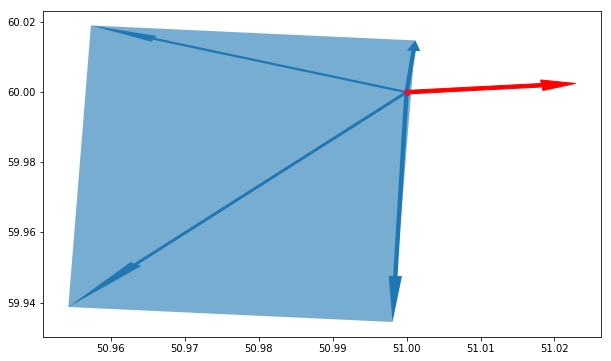

(array([-0.68137432, -0.1370024 ,  0.18807742, -0.86375063]), 2)


In [42]:
TrajStep([51., 60.])

[[ 75.73984  99.94482]
 [ 75.77347  99.96435]
 [ 75.76858 100.1018 ]
 [ 75.73497 100.0819 ]]


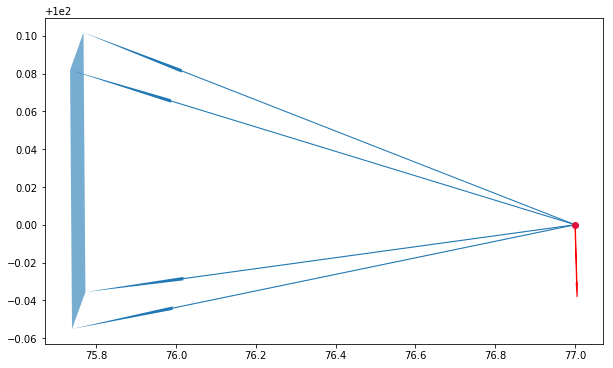

(array([-0.08509678, -0.0997372 , -0.19240772, -0.20987084]), 0)


In [43]:
Traj([77., 100.])

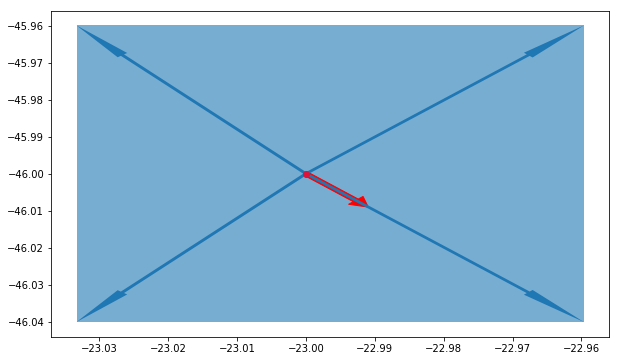

[ 0.08908543  0.99999923 -0.99556485  0.00644489]


In [205]:
Traj([-23., -46.])

[[0.         0.9999951 ]
 [0.07999998 0.9999951 ]
 [0.07999998 1.0799512 ]
 [0.         1.0799512 ]]


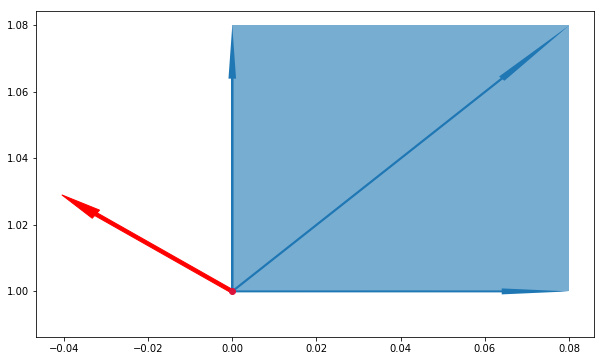

(array([-0.58255539, -0.8128266 ,  0.58255539, -0.16310224]), 2)


In [48]:
Traj([0., 1.])